## Coincidence Trigger

## Import Libraries

In [15]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger

# import subprocess
# import optparse
# from copy import deepcopy

# import numpy as np

# from obspy import UTCDateTime, Stream, read_inventory
# from obspy.core import AttribDict
# from obspy.signal import coincidenceTrigger

# from obspy.seishub import Client as SeishubClient
# from obspy.seedlink import Client as SeedlinkClient

# from seishub_event_templates import returnTemplates

## Configurations

In [22]:
config = {}

## before 2023-04-01
config['seeds'] = {"rotation":"PY.BSPF..HJ*", "translation":"II.PFO.10.BH*"}
## after 2023-04-01
# config['seeds'] = ["PY.BSPF..HJ*", "PY.PFOIX..HH*"]


# config['tbeg'] = obs.UTCDateTime("2022-10-03 16:00:00")
# config['tend'] = obs.UTCDateTime("2022-10-03 17:00:00")

config['tbeg'] = obs.UTCDateTime("2022-10-28 12:00:00")
config['tend'] = obs.UTCDateTime("2022-10-28 16:00:00")

config['output_path'] = "/home/andbro/kilauea-data/BSPF/trigger/"


config['client'] = Client("IRIS")

## Load Data

In [17]:
def __request_data(seed, client, tbeg, tend):

    print(seed)
    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print(f" -> Failed to load inventory for {seed}!")
        return

    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print(f" -> Failed to load waveforms for {seed}!")
        return
    
    return waveform, inventory

In [18]:
st_xpfo, inv_xpfo = __request_data(config['seeds']['translation'], config['client'], config['tbeg'], config['tend'])

II.PFO.10.BH*


In [ ]:
st_bspf, inv_bspf = __request_data(config['seeds']['rotation'], config['client'], config['tbeg'], config['tend'])

## Process Data

In [287]:
st_xpfo_proc = st_xpfo.copy()
st_xpfo_proc.remove_response(inventory=inv_xpfo)

st_bspf_proc = st_bspf.copy()
st_bspf_proc.remove_sensitivity(inventory=inv_bspf)
st_bspf_proc.resample(40.0)

3 Trace(s) in Stream:
PY.BSPF..HJ1 | 2022-10-28T11:59:00.001300Z - 2022-10-28T16:00:59.976300Z | 40.0 Hz, 580800 samples
PY.BSPF..HJ2 | 2022-10-28T11:59:00.001300Z - 2022-10-28T16:00:59.976300Z | 40.0 Hz, 580800 samples
PY.BSPF..HJ3 | 2022-10-28T11:59:00.001300Z - 2022-10-28T16:00:59.976300Z | 40.0 Hz, 580800 samples

In [300]:
st = obs.Stream()

st += st_bspf_proc.copy()
st += st_xpfo_proc.copy()

st.detrend("linear")
st.taper(0.01)
st.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=4, zerophase=True)  # optional prefiltering

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


6 Trace(s) in Stream:
PY.BSPF..HJ1  | 2022-10-28T11:59:00.001300Z - 2022-10-28T16:00:59.976300Z | 40.0 Hz, 580800 samples
PY.BSPF..HJ2  | 2022-10-28T11:59:00.001300Z - 2022-10-28T16:00:59.976300Z | 40.0 Hz, 580800 samples
PY.BSPF..HJ3  | 2022-10-28T11:59:00.001300Z - 2022-10-28T16:00:59.976300Z | 40.0 Hz, 580800 samples
II.PFO.10.BH1 | 2022-10-28T11:59:00.019538Z - 2022-10-28T16:00:59.994538Z | 40.0 Hz, 580800 samples
II.PFO.10.BH2 | 2022-10-28T11:59:00.019538Z - 2022-10-28T16:00:59.994538Z | 40.0 Hz, 580800 samples
II.PFO.10.BHZ | 2022-10-28T11:59:00.019538Z - 2022-10-28T16:00:59.994538Z | 40.0 Hz, 580800 samples

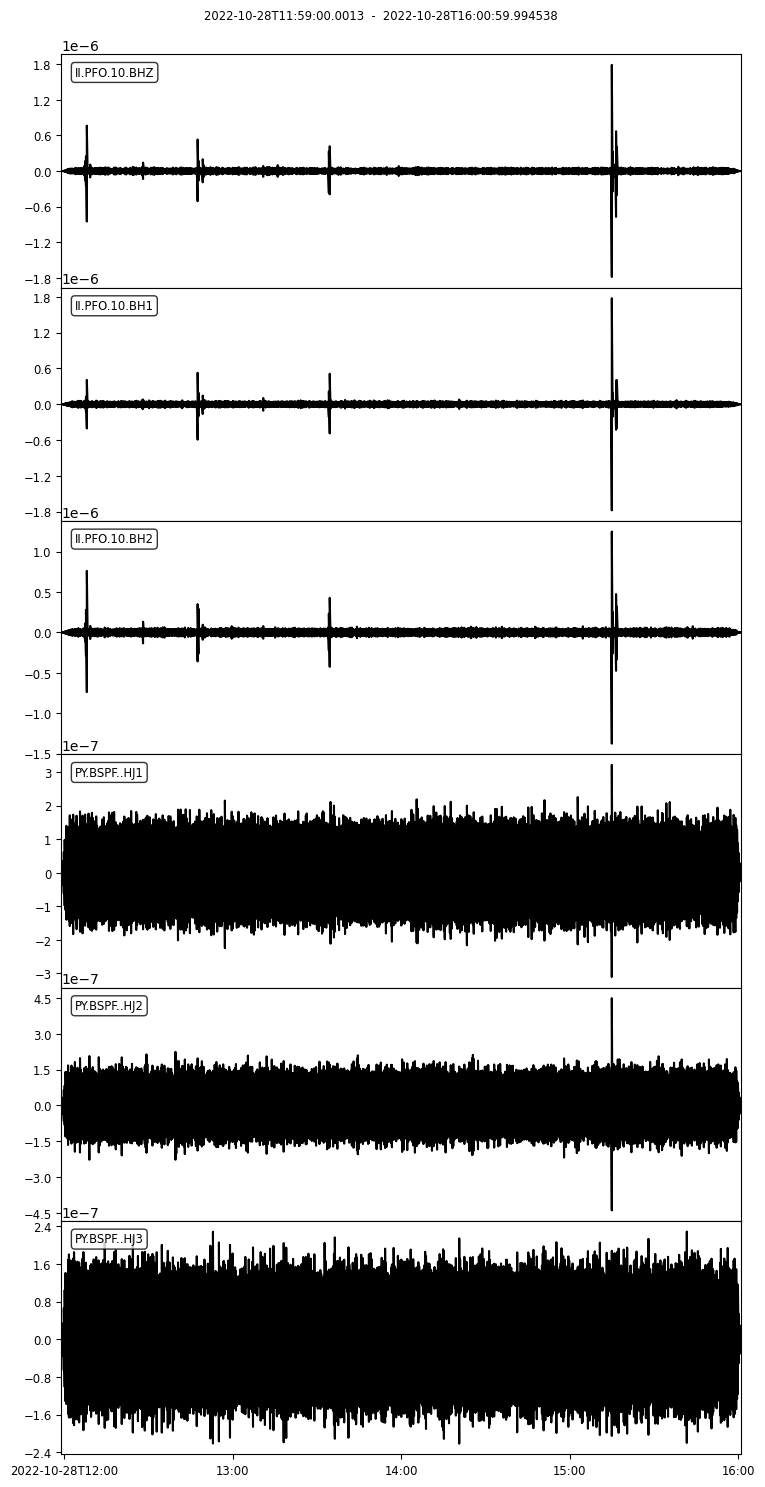

In [302]:
st.plot(equal_scale=False);

## Launch Trigger

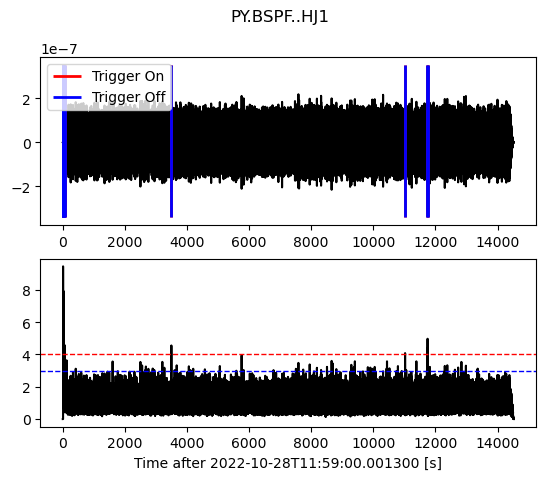

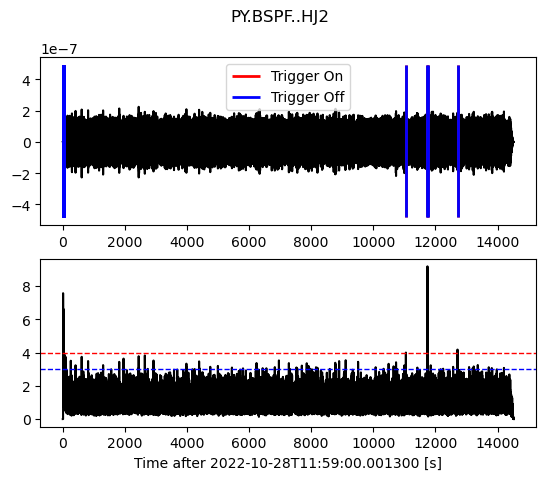

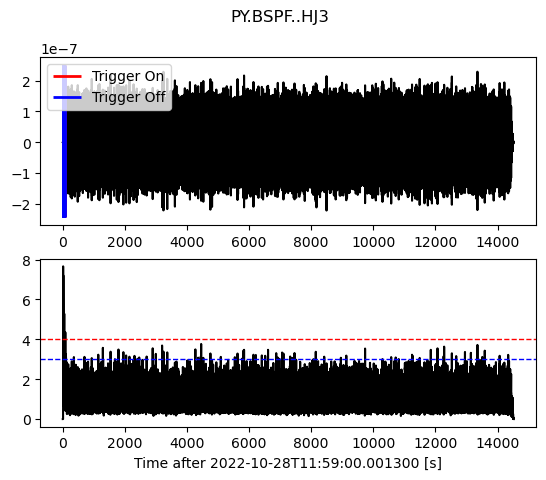

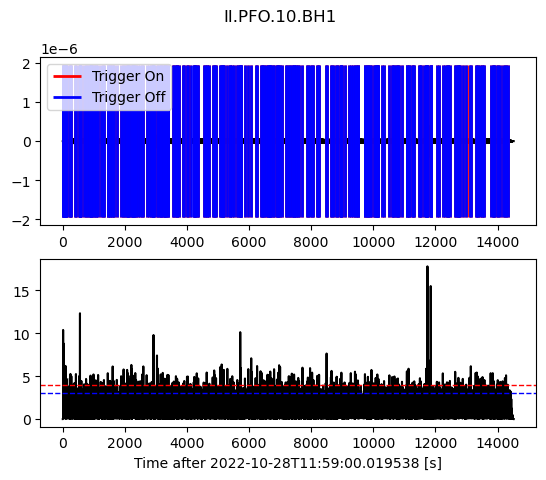

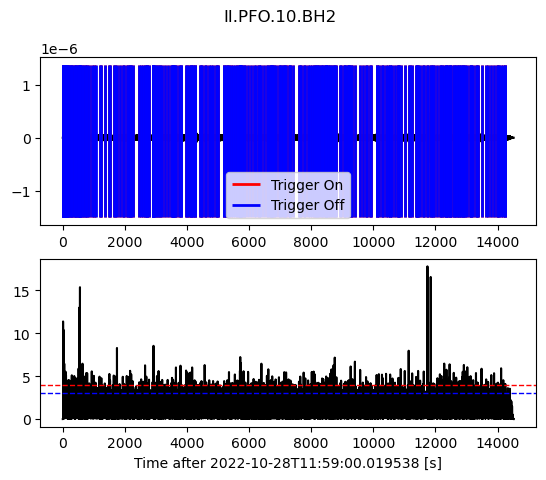

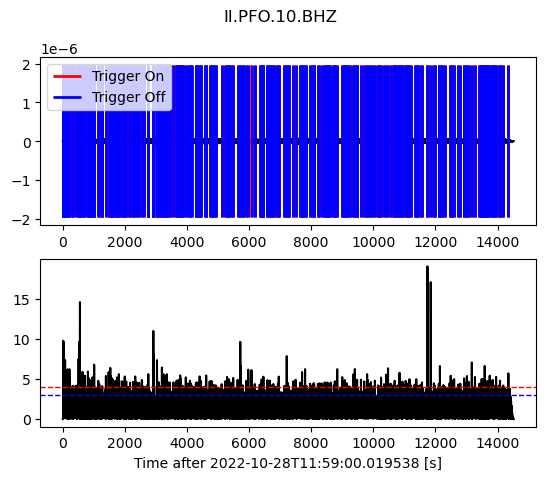

[]


In [303]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset, plot_trigger
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

st2 = st.copy()

df = st[0].stats.sampling_rate

config['trigger_type'] = 'recstalta'
config['thr_on'] = 4  ## thr_on (float) – threshold for switching single station trigger on
config['thr_off'] = 3.5 ## thr_off (float) – threshold for switching single station trigger off
config['lta'] = int(10*df)
config['sta'] = int(0.5*df)
config['thr_coincidence_sum'] = 4
config['similarity_thresholds'] = {"BSPF": 0.8, "PFO": 0.7}

       
for ii in range(len(st)):
    tr = st[ii]

    cft = recursive_sta_lta(tr.data, config['sta'], config['lta'])

    on_off = trigger_onset(cft, config['thr_on'], config['thr_off'])

    plot_trigger(tr, cft, config['thr_on'], config['thr_off'])



trig = coincidence_trigger(config['trigger_type'],
                           config['thr_on'],
                           config['thr_off'],
                           stream = st2, 
                           thr_coincidence_sum = config['thr_coincidence_sum'], 
                           sta=config['sta'], 
                           lta=config['lta'],
                          )

pprint(trig)

In [ ]:
times = st[0].times("utcdatetime")

plt.plot(st[0].times(), st[0].data)

for jj, trg in enumerate(trig):
    t1, t2 = trg['time']-st[0].times("utcdatetime")[0], (trg['time']-st[0].times("utcdatetime")[0])+trg['duration']
    plt.fill_between([t1, t2], min(st[0].data), max(st[0].data), color="red", alpha=0.5, zorder=0)

plt.show();